In [35]:
import geopandas as gpd
import shapely
from geovoronoi import voronoi_regions_from_coords
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from sklearn.cluster import KMeans, DBSCAN
import random
from shapely.geometry import Point
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import logging
%matplotlib inline

In [36]:
logging.basicConfig(filename='split_blocks.log', 
                    level=logging.INFO,
                    format='%(asctime)s.%(msecs)03d %(name)s - %(levelname)s - %(message)s',
                    datefmt="%Y-%m-%d %H:%M:%S")

In [2]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [3]:
def generate_random(number, polygon):
    '''
    from https://gis.stackexchange.com/questions/207731/generating-random-coordinates-in-multipolygon-in-python
    modified to output a geopandas df
    '''
    points = []
    minx, miny, maxx, maxy = polygon.bounds
    while len(points) < number:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(pnt):
            points.append(pnt)
            
    points_df = gpd.GeoDataFrame(pd.DataFrame(range(len(points)),columns=['pt_id']),
                            crs="EPSG:4326",
                            geometry=points)
    return points_df

def add_random_pts(address_points_for_cluster):
    '''
    '''
    random_extent = 0.0001
    new_point_list = []
    for point in address_points_for_cluster:
        minx = point[0]-random_extent
        maxx = point[0]+random_extent
        miny = point[1]-random_extent
        maxy = point[1]+random_extent
        new_point_list.append((random.uniform(minx, maxx), random.uniform(miny, maxy)))
    address_points_plus_rand = np.vstack((address_points_for_cluster,np.array(new_point_list)))
    return address_points_plus_rand

def split_poly_into_equal_parts(poly, num_parts):
    '''
    '''
    points_df = generate_random(2500, poly)
    km = KMeans(n_clusters=num_parts)
    
    points_df.loc[:,'lat'] = points_df.loc[:,'geometry'].apply(lambda x: x.y)
    points_df.loc[:,'lon'] = points_df.loc[:,'geometry'].apply(lambda x: x.x)
    points_for_cluster = points_df.copy()
    points_for_cluster.drop(labels=['geometry','pt_id'],axis=1,inplace=True)
    
    kmcls = km.fit(points_for_cluster.values)
    
    points_w_cl = points_df.assign(cluster=kmcls.labels_)
    centers = kmcls.cluster_centers_
    
    centers_gseries = gpd.GeoSeries(map(Point, zip(centers[:,1], centers[:,0])))
    
    centroid_coords = np.array([coords for coords in (zip(centers[:,1], centers[:,0]))])
    
    poly_shapes, pts, poly_to_pt_assignments  = voronoi_regions_from_coords(centroid_coords, poly)
    
    poly_shapes_df = gpd.GeoDataFrame(pd.DataFrame(poly_to_pt_assignments,columns=['group']),
                            crs="EPSG:4326",
                            geometry=poly_shapes)
    
    return poly_shapes_df

def split_one_poly_into_parts(square_id):
    '''
    '''
    one_square = squares[squares.loc[:,'SQUARE']==square_id].copy()
    address_pts = addresses[addresses.loc[:,'SQUARE']==square_id].copy()
    address_points_for_cluster = address_pts[['LATITUDE', 'LONGITUDE']].values
    if len(address_points_for_cluster)<4:
        split_type = "equal_area"
        poly_shapes_df = split_poly_into_equal_parts(one_square.unary_union, 4)
    else:
        split_type = "address_cluster"
        km_silhouette = {}
        max_cluster = min(10,len(address_points_for_cluster))
    #     print(f"max_num_clusters = {max_cluster-1}")
        for i in range(2,max_cluster):
            km = KMeans(n_clusters=i, random_state=0).fit(address_points_for_cluster)
            preds = km.predict(address_points_for_cluster)

            silhouette = silhouette_score(address_points_for_cluster,preds)
            km_silhouette[silhouette] = i
    #         print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    #         print("-"*100)
        best_num_clusters = max(4,km_silhouette[max(km_silhouette.keys())])
        km = KMeans(n_clusters=best_num_clusters, random_state=0).fit(address_points_for_cluster)
        centers = km.cluster_centers_
        centroid_coords = np.array([coords for coords in (zip(centers[:,1], centers[:,0]))])
        centers_gseries = gpd.GeoSeries(map(Point, zip(centers[:,1], centers[:,0])))
        address_pts_w_cluster = address_pts.assign(cluster=km.labels_)
        centroid_filtered = centers_gseries[centers_gseries.apply(lambda x: one_square.unary_union.contains(x))].copy()
        centroid_coords_filtered = np.array([coords for coords in (zip(centroid_filtered.apply(lambda x: x.x), 
                                    centroid_filtered.apply(lambda x: x.y)))])
        
        poly_shapes, pts, poly_to_pt_assignments  = voronoi_regions_from_coords(centroid_coords_filtered, one_square.unary_union)

        poly_shapes_df = gpd.GeoDataFrame(pd.DataFrame(poly_to_pt_assignments,columns=['group']),
                                crs="EPSG:4326",
                                geometry=poly_shapes)
    
    poly_shapes_export = poly_shapes_df.assign(square=square_id)
        
    return poly_shapes_export

def split_one_poly_into_parts_forplotting(square_id):
    '''
    '''
    one_square = squares[squares.loc[:,'SQUARE']==square_id].copy()
    address_pts = addresses[addresses.loc[:,'SQUARE']==square_id].copy()
    address_points_for_cluster = address_pts[['LATITUDE', 'LONGITUDE']].values
    if len(address_points_for_cluster)<4:
        split_type = "equal_area"
        poly_shapes_df = split_poly_into_equal_parts(one_square.unary_union, 4)
    else:
        split_type = "address_cluster"
        km_silhouette = {}
        max_cluster = min(10,len(address_points_for_cluster))
    #     print(f"max_num_clusters = {max_cluster-1}")
        for i in range(2,max_cluster):
            km = KMeans(n_clusters=i, random_state=0).fit(address_points_for_cluster)
            preds = km.predict(address_points_for_cluster)

            silhouette = silhouette_score(address_points_for_cluster,preds)
            km_silhouette[silhouette] = i
    #         print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    #         print("-"*100)
        best_num_clusters = max(4,km_silhouette[max(km_silhouette.keys())])
        km = KMeans(n_clusters=best_num_clusters, random_state=0).fit(address_points_for_cluster)
        centers = km.cluster_centers_
        centroid_coords = np.array([coords for coords in (zip(centers[:,1], centers[:,0]))])
        centers_gseries = gpd.GeoSeries(map(Point, zip(centers[:,1], centers[:,0])))
        address_pts_w_cluster = address_pts.assign(cluster=km.labels_)
        centroid_filtered = centers_gseries[centers_gseries.apply(lambda x: one_square.unary_union.contains(x))].copy()
        centroid_coords_filtered = np.array([coords for coords in (zip(centroid_filtered.apply(lambda x: x.x), 
                                    centroid_filtered.apply(lambda x: x.y)))])
        
        poly_shapes, pts, poly_to_pt_assignments  = voronoi_regions_from_coords(centroid_coords_filtered, one_square.unary_union)

        poly_shapes_df = gpd.GeoDataFrame(pd.DataFrame(poly_to_pt_assignments,columns=['group']),
                                crs="EPSG:4326",
                                geometry=poly_shapes)
    
    poly_shapes_export = poly_shapes_df.assign(square=square_id)
        
    return (poly_shapes_export, address_pts, one_square)

# Load the DC `squares` (I think of them as city blocks)

In [4]:
squares = gpd.read_file("gis_data/Square_Boundaries-shp/")

In [5]:
squares.head(3)

,OBJECTID,GIS_ID,CREATION_D,RECORDATIO,NARRATIVE,EXPIRATION,STATUS,SQUARE,SUFFIX,COMPUTED_A,...,SQUAREPLYI,FIT_ROTATI,FIT_ROTA_1,FIT_ROTA_2,SW_CORNER_,SW_CORNE_1,KILL_DT,SHAPEAREA,SHAPELEN,geometry
0,2717682,1174138.0,2006-09-09,1970-01-01,DELIVERY 12,1970-01-01,1,6239,S,401844,...,None,NaN,NaN,NaN,NaN,NaN,1970-01-01,37332.666173,1167.603867,"POLYGON ((-77.00694 38.82504, -77.00632 38.824..."
1,2717683,1177508.0,2006-09-09,1970-01-01,DELIVERY 6,1970-01-01,1,1303,None,105420,...,None,NaN,NaN,NaN,NaN,NaN,1970-01-01,9793.879221,438.912894,"POLYGON ((-77.06988 38.91432, -77.06987 38.914..."
2,2717684,1173503.0,2006-09-09,1970-01-01,DELIVERY 12,1970-01-01,1,5521,None,157309,...,None,NaN,NaN,NaN,NaN,NaN,1970-01-01,14614.509037,550.917664,"POLYGON ((-76.94705 38.86496, -76.94705 38.864..."


# load `address_pts`

In [6]:
addresses = gpd.read_file("gis_data/Address_Points-shp/")

In [7]:
addresses.shape

(148157, 59)

In [8]:
addresses.head(3)

,OBJECTID_1,OBJECTID,SITE_ADDRE,ADDRESS_ID,ROADWAYSEG,STATUS,SSL,TYPE_,ENTRANCETY,ADDRNUM,...,ACTIVE_RES,RES_TYPE,ACTIVE_R_1,WARD_2002,WARD_2012,ANC_2002,ANC_2012,SMD_2002,SMD_2012,geometry
0,832017,1087.0,27746,27746,11690.0,ACTIVE,0814 0018,ADDRESS,OFFICIAL,402.0,...,0.0,RESIDENTIAL,1.0,Ward 6,Ward 6,ANC 6C,ANC 6C,SMD 6C07,SMD 6C03,POINT (-77.00035 38.89220)
1,832018,3265.0,50808,50808,3073.0,ACTIVE,0838 0027,ADDRESS,OFFICIAL,219.0,...,0.0,RESIDENTIAL,1.0,Ward 6,Ward 6,ANC 6C,ANC 6C,SMD 6C07,SMD 6C03,POINT (-76.99925 38.89265)
2,832019,3266.0,51065,51065,3073.0,ACTIVE,0814 0818,ADDRESS,OFFICIAL,216.0,...,1.0,RESIDENTIAL,2.0,Ward 6,Ward 6,ANC 6C,ANC 6C,SMD 6C07,SMD 6C03,POINT (-76.99977 38.89256)


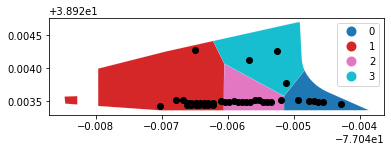

In [9]:
square_id = '2547'
poly_shapes_df, address_pts, one_square = split_one_poly_into_parts_forplotting(square_id)
fig, ax = plt.subplots()
poly_shapes_df.plot(column='group', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)
address_pts.plot(ax=ax, color='black')

In [10]:
import multiprocessing

n_pools = 2
pool = multiprocessing.Pool(n_pools)

In [11]:
squares_list = squares.loc[:,'SQUARE'].unique().tolist()

In [19]:
len(squares_list)

4420

In [22]:
result = pd.DataFrame()
for idx, shape_id in enumerate(squares_list):
    try:
        part_result = split_one_poly_into_parts(shape_id)
        if result.empty:
            result = part_result.copy()
        else:
            result = result.append(part_result)
    except:
        logging.info(f"bad shape -- {shape_id}")
    if idx%100 == 0:
        result.to_file("output/result.geojson",driver="GeoJSON")

bad shape -- 3811
bad shape -- 5176
bad shape -- 5905
bad shape -- 1892
bad shape -- 1003
bad shape -- 5584


TopologyException: Input geom 1 is invalid: Self-intersection at or near point -76.928458752785787 38.879316852307149 at -76.928458752785787 38.879316852307149


bad shape -- 5342
bad shape -- 2349
bad shape -- 5489
bad shape -- 1048
bad shape -- 0389
bad shape -- 3384
bad shape -- 2786
bad shape -- 0855
bad shape -- 3031
bad shape -- 5498
bad shape -- 2744
bad shape -- 3733
bad shape -- 2888
bad shape -- 4108
bad shape -- 1301
bad shape -- 0012
bad shape -- 5494
bad shape -- 1447
bad shape -- 6223
bad shape -- 2773
bad shape -- 3636
bad shape -- 5349
bad shape -- 2726
bad shape -- 0141
bad shape -- 5129
bad shape -- 3201
bad shape -- 1029
bad shape -- 3891
bad shape -- 1300
bad shape -- 0827
bad shape -- 2006
bad shape -- 3199
bad shape -- 0002
bad shape -- 3507
bad shape -- 3200
bad shape -- 0463
bad shape -- 5744
bad shape -- 6271
bad shape -- 5495
bad shape -- 3361
bad shape -- 0884
bad shape -- 2272
bad shape -- 5318
bad shape -- 5375
bad shape -- 0640
bad shape -- 0327
bad shape -- 3535
bad shape -- 0552
bad shape -- 3198
bad shape -- 5659
bad shape -- 0391
bad shape -- 0861
bad shape -- 5912
bad shape -- 0721
bad shape -- 3768
bad shape 